In [ ]:
Устанавливаем дополнительные библиотеки

In [9]:
!pip3 install tensorflow
!pip3 install opencv-python
!pip3 install keras-segmentation

In [ ]:
Библиотеки, необходимые для этого блокнота

In [10]:
import cv2
import os
import cv2
import glob
import json
import numpy as np
import tensorflow as tf
from keras.layers import *
from matplotlib import pyplot as plt
from keras_segmentation.models.model_utils import get_segmentation_model

2024-02-21 23:13:26.016455: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-21 23:13:26.085604: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-21 23:13:26.088120: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-21 23:13:27.128601: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [ ]:
Загружаем датасет и обученные веса.

In [11]:
!wget --no-check-certificate  'https://docs.google.com/uc?export=download&id=1dsdW4KgEH_Rr9rU468hUbcKc1CnYeU9w' -O MLtest_dataset.tar.xz
!tar -xvf MLtest_dataset.tar.xz 

!wget --no-check-certificate \
 'https://docs.google.com/uc?export=download&id=1ttWSv-Sd5hdhVPcxpbWDY3ZbjS51_l1d' -O best.h5
 

--2024-02-21 23:13:30--  https://docs.google.com/uc?export=download&id=1dsdW4KgEH_Rr9rU468hUbcKc1CnYeU9w
Распознаётся docs.google.com (docs.google.com)… 108.177.14.194, 2a00:1450:4010:c0f::c2
Подключение к docs.google.com (docs.google.com)|108.177.14.194|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 303 See Other
Адрес: https://drive.usercontent.google.com/download?id=1dsdW4KgEH_Rr9rU468hUbcKc1CnYeU9w&export=download [переход]
--2024-02-21 23:13:30--  https://drive.usercontent.google.com/download?id=1dsdW4KgEH_Rr9rU468hUbcKc1CnYeU9w&export=download
Распознаётся drive.usercontent.google.com (drive.usercontent.google.com)… 142.250.74.65, 2a00:1450:400f:802::2001
Подключение к drive.usercontent.google.com (drive.usercontent.google.com)|142.250.74.65|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: 68710648 (66M) [application/octet-stream]
Сохранение в: «MLtest_dataset.tar.xz»

MLtest_dataset.tar. 100%[===================>]  65

In [ ]:
Модель нейросети с некоторыми настраиваемыми слоями

In [12]:
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'  # 0-GPU -1-CPU
#physical_devices = tf.config.experimental.list_physical_devices('GPU')
#assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
#config = tf.config.experimental.set_memory_growth(physical_devices[0], True)
#session = tf.compat.v1.keras.backend.get_session()


def get_image_arr(path, width, height, imgNorm="sub_mean", odering='channels_first'):
    """
       Transform images for   neural network
       :param path: image or path
       :param width: width
       :param height:  image
       :return: transfotm images
    """
    if type(path) is np.ndarray:
        img = path
    else:
        img = cv2.imread(path, 1)

    if imgNorm == "sub_and_divide":
        img = np.float32(cv2.resize(img, (width, height))) / 127.5 - 1
    elif imgNorm == "sub_mean":
        img = cv2.resize(img, (width, height))
        img = img.astype(np.float32)
        img[:, :, 0] -= 103.939
        img[:, :, 1] -= 116.779
        img[:, :, 2] -= 123.68
        img = img[:, :, ::-1]
    elif imgNorm == "divide":
        img = cv2.resize(img, (width, height))
        img = img.astype(np.float32)
        img = img / 255.0

    if odering == 'channels_first':
        img = np.rollaxis(img, 2, 0)
    return img


def predict_my(model=None, inp=None):
    """
       Recognition images
       :param model: model neural network
       :param inp:  image
       :return: result neural network
    """
    assert len(inp.shape) == 3, "Image should be h,w,3 "
    output_width = model.output_width
    output_height = model.output_height
    input_width = model.input_width
    input_height = model.input_height
    n_classes = model.n_classes
    x = get_image_arr(inp, input_width, input_height, odering='channels_last')
    pr = model.predict(np.array([x]))[0]
    pr = pr.reshape((output_height, output_width, n_classes)).argmax(axis=2)
    return np.array(pr, dtype=np.uint8)


def railway_unet(frame, model,n_classes: int, limit_box_width_height: list, name_images: str)->dict:
    """
       Recognition images
       :param frame: model neural network
       :param  model:  image
       :param  n_classes:  image
       :param  limit_box_width_height:  image
       :param  model:  image
       :return: result neural network
    """

    img = predict_my(model=model, inp=frame)
    color = {1: (255, 100, 0), 2: (0, 100, 255), 3: (5, 255, 0)}
    account_classes = {1: 0, 2: 0, 3: 0}

    for c in range(1, n_classes, 1):
        only_cat_hsv = cv2.inRange(img, c, c)
        contours, hierarchy = cv2.findContours(only_cat_hsv, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        for cnt in contours:
            box = cv2.boundingRect(cnt)
            if clinket_rail(box, limit_box_width_height):
                frame = cv2.rectangle(frame, (box[0], box[1]), (box[0] + box[2], box[1] + box[3]), color[c], 5)
                account_classes[c] += 1
    print(f'Images {name_images}  Mixed: {account_classes[2]}, Dense: {account_classes[1]}, Diffuse: {account_classes[3]}.')
    plt.imshow(frame)
    plt.show()
    return account_classes

def merge_dicts(dict1, dict2):
    """
       Account recognitions classes
       :param dict1:  current recognitions classes
       :param dict2: new recognitions classes
       :return: all result recognitions classes
       """
    return {k: dict1.get(k, 0) + dict2.get(k, 0) for k in set(dict1) | set(dict2)}


def clinket_rail(box: list, limit: list)->bool:
    """
        Сut off noise
        :param box: recognition class coordinates
        :param limit:  limitation on the height and width of the object
        :return: flag
        """
    return box[2] > limit[0] and box[3] > limit[1]


def net(n_classes: int, height: int, width: int, train: bool, epochs: int):
    """
    Create a neural network for the segmentation
    :param n_classes:  quantity classes neutral network
    :param height:  height image
    :param width:   width image
    :param train:   Flag on/off train
    :param epochs:  quantity epoch
    :return: Model segmentation
    """
    img_input = Input(shape=(height, width, 3))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(img_input)
    conv1 = Dropout(0.2)(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Dropout(0.2)(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Dropout(0.2)(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Dropout(0.2)(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    up0 = concatenate([UpSampling2D((2, 2))(conv4), conv3], axis=-1)
    conv41 = Conv2D(128, (3, 3), activation='relu', padding='same')(up0)
    conv41 = Dropout(0.2)(conv41)
    conv41 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv41)
    up1 = concatenate([UpSampling2D((2, 2))(conv41), conv2], axis=-1)
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(up1)
    conv4 = Dropout(0.2)(conv4)
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv4)
    up2 = concatenate([UpSampling2D((2, 2))(conv4), conv1], axis=-1)
    conv5 = Conv2D(32, (3, 3), activation='relu', padding='same')(up2)
    conv5 = Dropout(0.2)(conv5)
    conv5 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv5)
    out = Conv2D(n_classes, (1, 1), padding='same')(conv5)

    model = get_segmentation_model(img_input, out)  # this would build the segmentation model
    if train == True:
        model.train(
            train_images="images_prepped_train/",
            train_annotations="annotations_prepped_train/",
            checkpoints_path="content/", epochs=epochs)
        model.save('last.h5')

    return model


# params model
n_classes = 4
height = 768
width = 768
# created model
model = net(n_classes=n_classes, height=height, width=width, train=False, epochs=2)
print(model.summary())


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 768, 768, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 768, 768, 32)         896       ['input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 768, 768, 32)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 768, 768, 32)         9248      ['dropout[0][0]']             
                                                                                            

In [ ]:
Предварительная обработка и разделение данных

In [15]:
def created_dir():
    """
    Created directory
    """
    if not os.path.exists("annotations_prepped_train"):
        os.makedirs("annotations_prepped_train")

    if not os.path.exists("images_prepped_train"):
        os.makedirs("images_prepped_train")

    if not os.path.exists("content"):
        os.makedirs("content")


def read_annotations():
    """
    Read annotations file
    """
    annotation = {}
    for v in glob.glob('MLtest_dataset/MLtest_json (*).json'):
        with open(v, 'r') as f:
            json_annotation = json.load(f)
            for key, cap in json_annotation.items():
                if key in annotation:
                    annotation[key]['regions'] += cap['regions']
                else:
                    annotation[key] = cap
    return annotation


def created_mask(annotation: dict,height: int, width: int ):
    """
    Created mask
    :param annotation: dict annotations datasets       
    """
    
    color = {'Mixed': (1, 1, 1), 'Dense': (2, 2, 2), 'Diffuse': (3, 3, 3)}
    
    for key, value in annotation.items():
        name_photo = f"MLtest_dataset/{value['filename']}"
        try:
            img = cv2.imread(name_photo)
            msk_img = np.zeros((height, width, 3), dtype='uint8')
            for b in value['regions']:
                crd = b["shape_attributes"]
                if 'Type' in b["region_attributes"]:
                    x_min = int((crd["x"] * msk_img.shape[1]) / img.shape[1])
                    y_min = int((crd["y"] * msk_img.shape[0]) / img.shape[0])
                    x_max = int(((crd["width"] + crd["x"]) * msk_img.shape[1]) / img.shape[1])
                    y_max = int(((crd["height"] + crd["y"]) * msk_img.shape[0]) / img.shape[0])
                    box = np.array([[[x_min, y_min], [x_max, y_min], [x_max, y_max], [x_min, y_max]]], dtype=np.int32)
                    cv2.fillPoly(msk_img, box, color[b["region_attributes"]["Type"]])
            img = cv2.resize(img, (height, width))
            cv2.imwrite('images_prepped_train/' + value['filename'].replace('jpg', 'png'), img)
            cv2.imwrite('annotations_prepped_train/' + value['filename'].replace('jpg', 'png'), msk_img)
        except Exception as e:
            print(f'err {e}')
            
created_dir()
annotation = read_annotations()
created_mask(annotation, height, width)


err OpenCV(4.9.0) /io/opencv/modules/imgproc/src/resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



[ WARN:0@967.893] global loadsave.cpp:248 findDecoder imread_('MLtest_dataset/чашка 1.jpg'): can't open/read file: check file path/integrity


In [ ]:
Обучение
Мне потребовалось некоторое время, чтобы обучить модель (4 часа процессорах). 
Так что просто напишем код для обучения и после этого загрузим обученную модель.

In [ ]:
model = net(n_classes=n_classes, height=height, width=width, train=True, epochs=200)

In [ ]:
Вывод по тестовым данным¶

1/1 [==============================] - 1s 1s/step
Images MLtest_dataset/чашка 8.1.jpg  Mixed: 41, Dense: 41, Diffuse: 24.


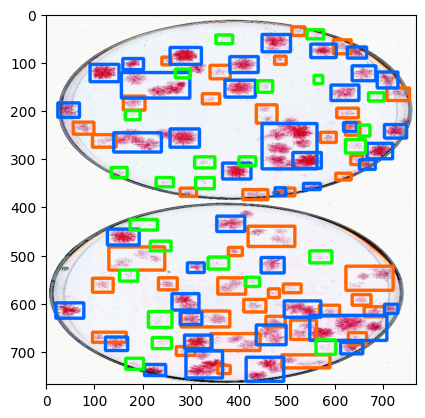

1/1 [==============================] - 1s 1s/step
Images MLtest_dataset/чашка 7.jpg  Mixed: 72, Dense: 94, Diffuse: 34.


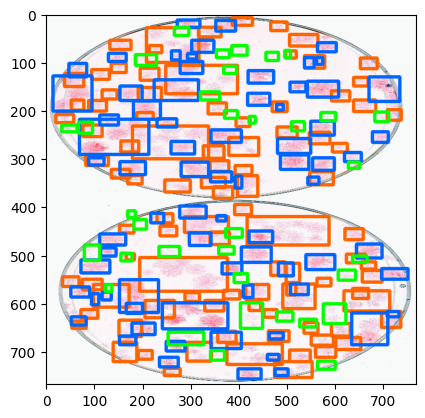

1/1 [==============================] - 1s 1s/step
Images MLtest_dataset/чашка 13.jpg  Mixed: 26, Dense: 64, Diffuse: 29.


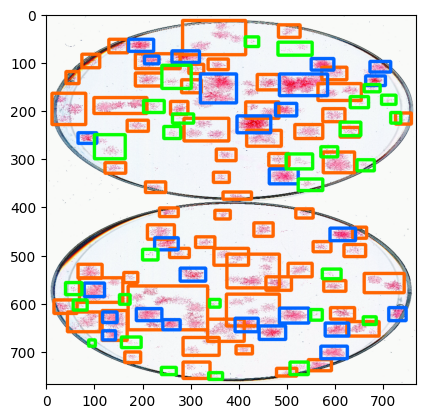

1/1 [==============================] - 1s 895ms/step
Images MLtest_dataset/чашка 10.jpg  Mixed: 43, Dense: 63, Diffuse: 16.


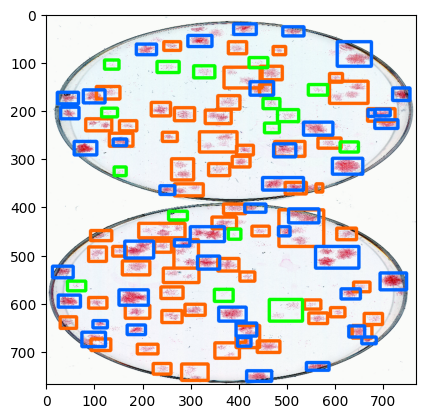

1/1 [==============================] - 1s 883ms/step
Images MLtest_dataset/чашка 9.jpg  Mixed: 28, Dense: 64, Diffuse: 19.


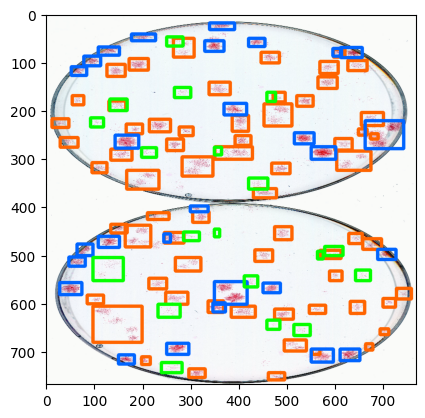

1/1 [==============================] - 1s 857ms/step
Images MLtest_dataset/чашка 12.jpg  Mixed: 33, Dense: 84, Diffuse: 20.


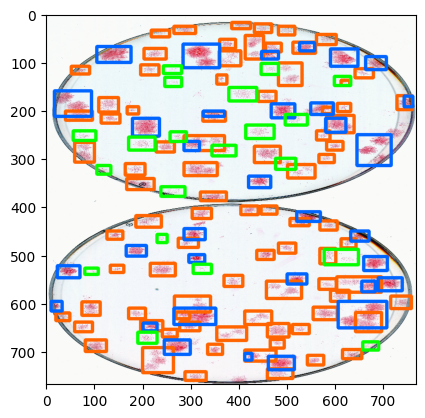

1/1 [==============================] - 1s 893ms/step
Images MLtest_dataset/чашка 6.jpg  Mixed: 21, Dense: 77, Diffuse: 36.


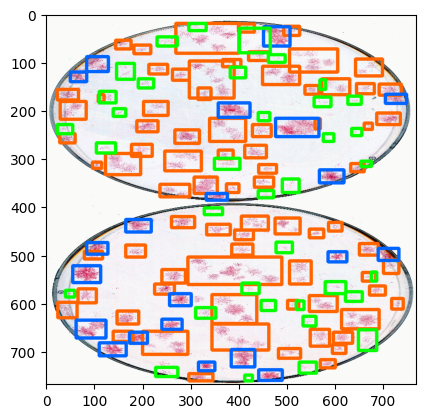

1/1 [==============================] - 1s 1s/step
Images MLtest_dataset/чашка 5.jpg  Mixed: 1, Dense: 46, Diffuse: 65.


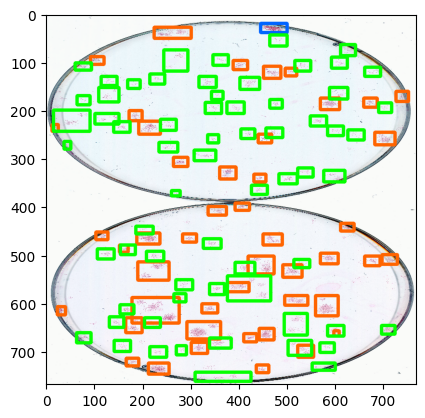

1/1 [==============================] - 1s 1s/step
Images MLtest_dataset/чашка 4.jpg  Mixed: 4, Dense: 48, Diffuse: 59.


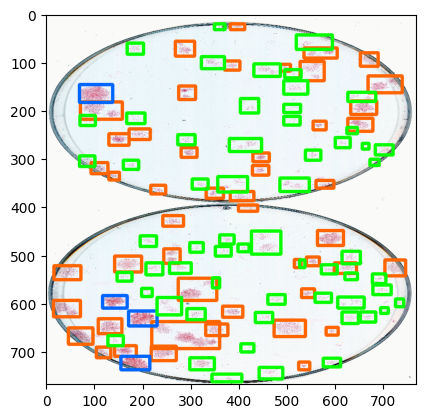

1/1 [==============================] - 1s 1s/step
Images MLtest_dataset/чашка 3.jpg  Mixed: 1, Dense: 40, Diffuse: 14.


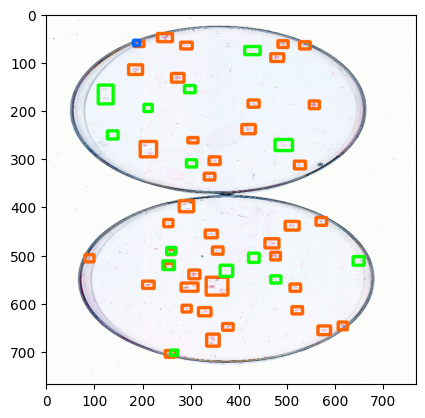

1/1 [==============================] - 1s 1s/step
Images MLtest_dataset/чашка 11.jpg  Mixed: 8, Dense: 47, Diffuse: 64.


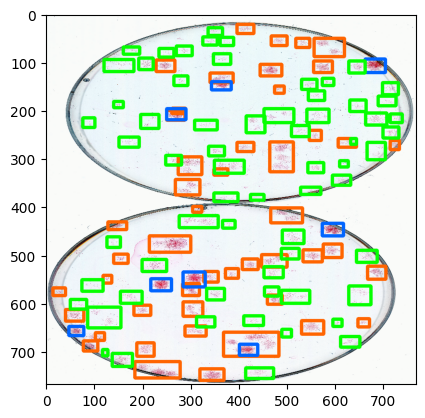

1/1 [==============================] - 1s 1s/step
Images MLtest_dataset/чашка 8.2.jpg  Mixed: 55, Dense: 64, Diffuse: 19.


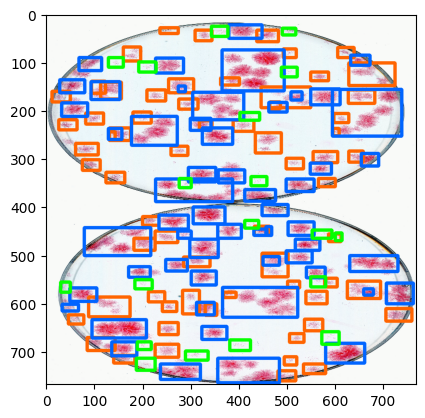

1/1 [==============================] - 1s 1s/step
Images MLtest_dataset/чашка 2.jpg  Mixed: 5, Dense: 30, Diffuse: 32.


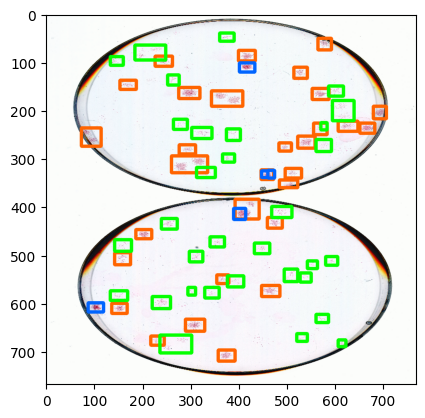

All classes bacteria: 762, Dense: 338, Diffuse: 431.


In [17]:
model.load_weights('best.h5')

limit_box_width_height = [10, 10]
account_classes_sum={}
for img_path in  glob.glob('MLtest_dataset/*.jpg'):
    frame = cv2.imread(img_path)
    frame = cv2.resize(frame, (width, height))
    account_classes = railway_unet(frame, model, n_classes, limit_box_width_height, img_path)
    account_classes_sum= merge_dicts(account_classes_sum, account_classes )
print( f'All classes bacteria: {account_classes_sum[1]}, Dense: {account_classes_sum[2]}, Diffuse: {account_classes_sum[3]}.')